In [41]:
from google.colab import auth
auth.authenticate_user()
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p gdrive
!google-drive-ocamlfuse gdrive
!pip install -q keras
!pip install numba
!pip install tqdm
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17)

    100% |████████████████████████████████| 14.8MB 92kB/s 
    100% |████████████████████████████████| 51kB 2.7MB/s 
Hit:1 http://security.ubuntu.com/ubuntu artful-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Hit:3 http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu artful InRelease
Hit:4 http://archive.ubuntu.com/ubuntu artful-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu artful-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
11 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


# MNIST autoencoder

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist
 
import numpy as np
import matplotlib.pyplot as plt

import re
import math

np.random.seed(123)

#Import MNIST

In [114]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train.shape

(60000, 28, 28, 1)

# Cut off the test/train sets
We are going to clear the right most 50% of all images before putting them through the autoencoder. With any luck, the model will learn how to complete the image.

CPU times: user 3.06 s, sys: 115 ms, total: 3.18 s
Wall time: 3.16 s


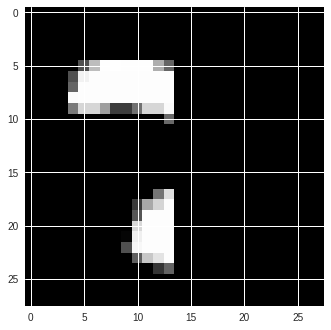

In [115]:
%%time
def image_cutoff(img):  
  l_y, l_x = img.shape[0], img.shape[1]
  Y, X = np.ogrid[:l_x, :l_y]
  outer_disk_mask = ((Y) >= 0) + (X) > l_x/2
  img[outer_disk_mask] = 0
  
  return img
  
  
X_train_cutoff = np.array([image_cutoff(x) for x in X_train])
X_test_cutoff = np.array([image_cutoff(x) for x in X_test])

plt.imshow(X_train_cutoff[28].reshape(28, 28))

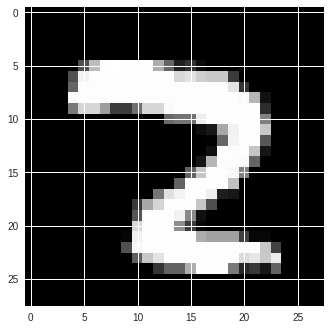

In [117]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

plt.imshow(X_train[28].reshape(28, 28))

# Create the model
Autoencoders shrink the image down to a small scale then restore them to full size as the output using Maxpooling and UpSampling respectively.

In [118]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='elu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='elu', padding='same'))
 
model.add(MaxPooling2D((2, 2), padding='same'))
 
model.add(Conv2D(8, (3, 3), activation='elu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='elu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='elu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='elu', padding='same'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 8)           584       
__________

In [119]:
model.fit(X_train_cutoff, X_train, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 7s 138us/step - loss: 0.0583 - val_loss: 0.0501
Epoch 2/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0469 - val_loss: 0.0439
Epoch 3/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0411 - val_loss: 0.0384
Epoch 4/100
35072/48000 [====================>.........] - ETA: 1s - loss: 0.0373

48000/48000 [==============================] - 6s 132us/step - loss: 0.0369 - val_loss: 0.0354
Epoch 5/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0343 - val_loss: 0.0336
Epoch 6/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0327 - val_loss: 0.0320
Epoch 7/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0315 - val_loss: 0.0311
Epoch 8/100
17152/48000 [=========>....................] - ETA: 3s - loss: 0.0310

48000/48000 [==============================] - 6s 132us/step - loss: 0.0307 - val_loss: 0.0306
Epoch 9/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0300 - val_loss: 0.0296
Epoch 10/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0295 - val_loss: 0.0294
Epoch 11/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0290 - val_loss: 0.0291
Epoch 12/100
14592/48000 [========>.....................] - ETA: 4s - loss: 0.0286

48000/48000 [==============================] - 6s 131us/step - loss: 0.0286 - val_loss: 0.0288
Epoch 13/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0283 - val_loss: 0.0280
Epoch 14/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0279 - val_loss: 0.0278
Epoch 15/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0276 - val_loss: 0.0274
Epoch 16/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0274

48000/48000 [==============================] - 6s 132us/step - loss: 0.0274 - val_loss: 0.0273
Epoch 17/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0271 - val_loss: 0.0270
Epoch 18/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0269 - val_loss: 0.0268
Epoch 19/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0267 - val_loss: 0.0267
Epoch 20/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0266

48000/48000 [==============================] - 6s 131us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 21/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0263 - val_loss: 0.0262
Epoch 22/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0261 - val_loss: 0.0261
Epoch 23/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0261 - val_loss: 0.0259
Epoch 24/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0261

48000/48000 [==============================] - 6s 131us/step - loss: 0.0259 - val_loss: 0.0262
Epoch 25/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 26/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0256 - val_loss: 0.0256
Epoch 27/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0255 - val_loss: 0.0257
Epoch 28/100
12544/48000 [======>.......................] - ETA: 4s - loss: 0.0255

48000/48000 [==============================] - 6s 132us/step - loss: 0.0254 - val_loss: 0.0255
Epoch 29/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0253 - val_loss: 0.0252
Epoch 30/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0252 - val_loss: 0.0252
Epoch 31/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 32/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0250

48000/48000 [==============================] - 6s 132us/step - loss: 0.0250 - val_loss: 0.0249
Epoch 33/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0249 - val_loss: 0.0249
Epoch 34/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0248 - val_loss: 0.0248
Epoch 35/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0248 - val_loss: 0.0248
Epoch 36/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0248

48000/48000 [==============================] - 6s 131us/step - loss: 0.0247 - val_loss: 0.0248
Epoch 37/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0246 - val_loss: 0.0248
Epoch 38/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0245 - val_loss: 0.0244
Epoch 39/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0245 - val_loss: 0.0248
Epoch 40/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0245

48000/48000 [==============================] - 6s 132us/step - loss: 0.0244 - val_loss: 0.0245
Epoch 41/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0244 - val_loss: 0.0243
Epoch 42/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0243 - val_loss: 0.0243
Epoch 43/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0242 - val_loss: 0.0243
Epoch 44/100
11520/48000 [======>.......................] - ETA: 4s - loss: 0.0241

48000/48000 [==============================] - 6s 131us/step - loss: 0.0242 - val_loss: 0.0242
Epoch 45/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0241 - val_loss: 0.0241
Epoch 46/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0240 - val_loss: 0.0242
Epoch 47/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0240 - val_loss: 0.0242
Epoch 48/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0240

48000/48000 [==============================] - 6s 132us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 49/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0239 - val_loss: 0.0241
Epoch 50/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0239 - val_loss: 0.0239
Epoch 51/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0238 - val_loss: 0.0240
Epoch 52/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0236

48000/48000 [==============================] - 6s 132us/step - loss: 0.0237 - val_loss: 0.0238
Epoch 53/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0236 - val_loss: 0.0237
Epoch 54/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0236 - val_loss: 0.0239
Epoch 55/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0236 - val_loss: 0.0236
Epoch 56/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0236

48000/48000 [==============================] - 6s 132us/step - loss: 0.0236 - val_loss: 0.0235
Epoch 57/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0235 - val_loss: 0.0236
Epoch 58/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0235 - val_loss: 0.0238
Epoch 59/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 60/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0232

48000/48000 [==============================] - 6s 133us/step - loss: 0.0234 - val_loss: 0.0234
Epoch 61/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0234 - val_loss: 0.0235
Epoch 62/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0233 - val_loss: 0.0237
Epoch 63/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0233 - val_loss: 0.0234
Epoch 64/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0232

48000/48000 [==============================] - 6s 132us/step - loss: 0.0232 - val_loss: 0.0233
Epoch 65/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0232 - val_loss: 0.0233
Epoch 66/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0232 - val_loss: 0.0231
Epoch 67/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0232 - val_loss: 0.0232
Epoch 68/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0230

48000/48000 [==============================] - 6s 132us/step - loss: 0.0231 - val_loss: 0.0231
Epoch 69/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0231 - val_loss: 0.0232
Epoch 70/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 71/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0229 - val_loss: 0.0230
Epoch 72/100
12544/48000 [======>.......................] - ETA: 4s - loss: 0.0230

48000/48000 [==============================] - 6s 132us/step - loss: 0.0230 - val_loss: 0.0232
Epoch 73/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0229 - val_loss: 0.0231
Epoch 74/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0229 - val_loss: 0.0231
Epoch 75/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0229 - val_loss: 0.0230
Epoch 76/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0228

48000/48000 [==============================] - 6s 132us/step - loss: 0.0228 - val_loss: 0.0230
Epoch 77/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0228 - val_loss: 0.0230
Epoch 78/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0228 - val_loss: 0.0228
Epoch 79/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0227 - val_loss: 0.0229
Epoch 80/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0227

48000/48000 [==============================] - 6s 132us/step - loss: 0.0227 - val_loss: 0.0227
Epoch 81/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0227 - val_loss: 0.0230
Epoch 82/100
48000/48000 [==============================] - 6s 133us/step - loss: 0.0227 - val_loss: 0.0228
Epoch 83/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0227 - val_loss: 0.0227
Epoch 84/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0225

48000/48000 [==============================] - 6s 132us/step - loss: 0.0226 - val_loss: 0.0227
Epoch 85/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0226 - val_loss: 0.0228
Epoch 86/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0226 - val_loss: 0.0230
Epoch 87/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0225 - val_loss: 0.0230
Epoch 88/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0225

48000/48000 [==============================] - 6s 131us/step - loss: 0.0225 - val_loss: 0.0226
Epoch 89/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0225 - val_loss: 0.0227
Epoch 90/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0224 - val_loss: 0.0226
Epoch 91/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0225 - val_loss: 0.0226
Epoch 92/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0224

48000/48000 [==============================] - 6s 132us/step - loss: 0.0224 - val_loss: 0.0227
Epoch 93/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0224 - val_loss: 0.0226
Epoch 94/100
48000/48000 [==============================] - 6s 131us/step - loss: 0.0224 - val_loss: 0.0225
Epoch 95/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0224 - val_loss: 0.0227
Epoch 96/100
13056/48000 [=======>......................] - ETA: 4s - loss: 0.0223

48000/48000 [==============================] - 6s 132us/step - loss: 0.0223 - val_loss: 0.0228
Epoch 97/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0223 - val_loss: 0.0226
Epoch 98/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0223 - val_loss: 0.0224
Epoch 99/100
48000/48000 [==============================] - 6s 132us/step - loss: 0.0223 - val_loss: 0.0224
Epoch 100/100
13568/48000 [=======>......................] - ETA: 4s - loss: 0.0222

48000/48000 [==============================] - 6s 133us/step - loss: 0.0223 - val_loss: 0.0224


# Sample from the test set

In [0]:
decoded_imgs = model.predict(X_test_cutoff)

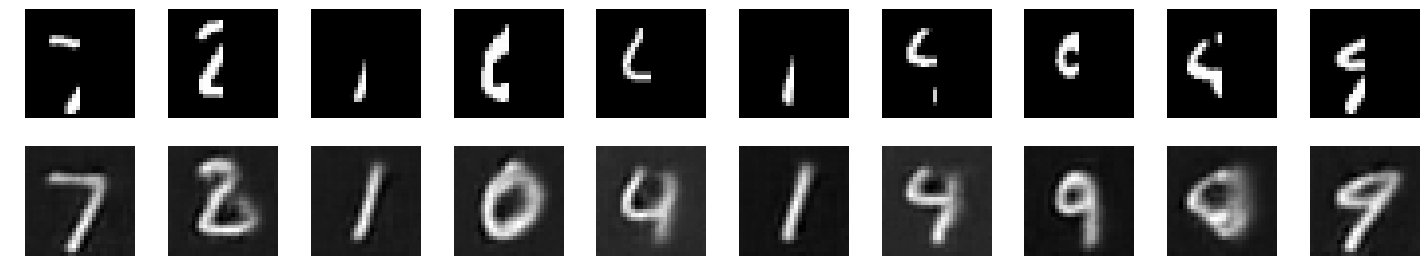

In [121]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_cutoff[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
 
    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [0]:
model.save("gdrive\MNIST\Sample_Cutoff_MNIST_Model.h5")